In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [2]:
device = torch.device('cpu')
model = models.vgg19(pretrained=True).features.to(device).eval()

In [3]:
l_content = ['conv_4']
l_style = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [4]:
def im_load(im_name):
    return loader(Image.open(im_name)).unsqueeze(0).to(device, torch.float)


def im_show(tensor, title=None):
    plt.imshow(unloader(tensor.cpu().clone().squeeze(0)))


def get_input_optimizer(im_input):
    return optim.LBFGS([im_input.requires_grad_()])


def get_style_model_and_losses(cnn,
                               norm_mean,
                               norm_std,
                               im_style,
                               im_content,
                               l_content=l_content,
                               l_style=l_style):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(norm_mean, norm_std).to(device)

    c_losses = []
    s_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in l_content:
            target = model(im_content).detach()
            c_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), c_loss)
            c_losses.append(c_loss)

        if name in l_style:
            target_feature = model(im_style).detach()
            s_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), s_loss)
            s_losses.append(s_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, s_losses, c_losses


def run_style_transfer(cnn,
                       norm_mean,
                       norm_std,
                       im_style,
                       im_content,
                       im_input,
                       num_steps=2500,
                       s_weight=2000_000_0,
                       c_weight=1):
    model, s_losses, c_losses = get_style_model_and_losses(cnn,
                                                           norm_mean,
                                                           norm_std,
                                                           im_style,
                                                           im_content)
    optimizer = get_input_optimizer(im_input)

    run = [0]
    while run[0] <= num_steps:
        def step():
            im_input.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(im_input)
            s_score = 0
            c_score = 0

            for s_loss in s_losses:
                s_score += s_loss.loss
            for c_loss in c_losses:
                c_score += c_loss.loss

            s_score *= s_weight
            c_score *= c_weight

            loss = s_score + c_score
            loss.backward()

            run[0] += 1

            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(s_score.item(), c_score.item()))
                print()

            return s_score + c_score

        optimizer.step(step)

    im_input.data.clamp_(0, 1)

    return im_input


class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.__gram(target_feature).detach()

    def forward(self, input):
        G = self.__gram(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
    def __gram(self,input):
        N, C, H, W = input.size()  
        features = input.view(N * C, H * W) 
        G = torch.mm(features, features.t()) 
        return G.div(N * C * H * W)


class Normalization(nn.Module):

    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [6]:
im_size = (170, 256)
loader = transforms.Compose([transforms.Resize(im_size), transforms.ToTensor()])  

im_style = im_load("./jojo.jpg")
im_content = im_load("./naz.jpg")

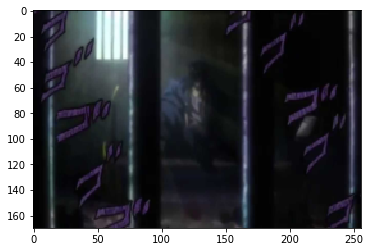

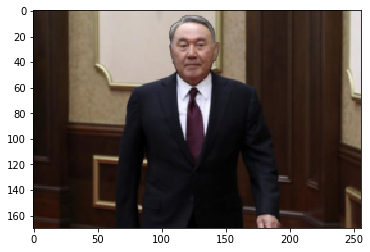

In [7]:
unloader = transforms.ToPILImage()  
plt.ion()

plt.figure()
im_show(im_style)

plt.figure()
im_show(im_content)

/home/pikalm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/pikalm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [100]:
Style Loss : 605.680237 Content Loss: 14.368560

run [200]:
Style Loss : 209.536026 Content Loss: 15.326395

run [300]:
Style Loss : 122.714157 Content Loss: 15.557516

run [400]:
Style Loss : 77.067345 Content Loss: 15.957483

run [500]:
Style Loss : 49.655247 Content Loss: 16.271576

run [600]:
Style Loss : 32.931915 Content Loss: 16.642515

run [700]:
Style Loss : 21.899269 Content Loss: 16.702009

run [800]:
Style Loss : 14.648536 Content Loss: 16.493107

run [900]:
Style Loss : 10.976357 Content Loss: 16.113909

run [1000]:
Style Loss : 8.789733 Content Loss: 15.778789

run [1100]:
Style Loss : 7.460546 Content Loss: 15.461792

run [1200]:
Style Loss : 6.588408 Content Loss: 15.164985

run [1300]:
Style Loss : 5.911793 Content Loss: 14.919187

run [1400]:
Style Loss : 5.378948 Content Loss: 14.699140

run [1500]:
Style Loss : 5.000577 Content Loss: 14.484194

run [1600]:
Style Loss : 4.780551 Content Loss: 14.279135

run [1700]:
Style Loss : 4.533955 Content Loss: 14.10

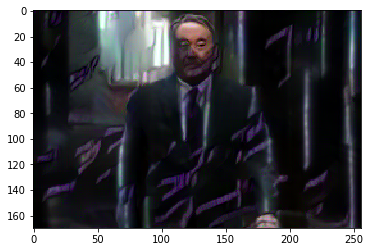

In [9]:
im_input = im_content.clone()

result = run_style_transfer(model, norm_mean, norm_std, im_style, im_content, im_input)

plt.figure()
im_show(result)
plt.ioff()
plt.show()